In [1]:
import os, sys
import random
import json
import nltk 
import csv
import time
import copy
import torch
import numpy as np
import pandas as pd
import nltk  # $ pip install nltk
from nltk.stem import PorterStemmer
from nltk.corpus import cmudict  # >>> nltk.download('cmudict')
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker # $ pip install pyspellchecker
import matplotlib.pyplot as plt
from datetime import datetime

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification

from beliefbank_data.utils import generate_assertion, generate_question, find_constraints, generate_inverse_question, generate_question_with_context
import correction_utils

# Load data

In [2]:
constraints_path = "beliefbank_data/constraints_v2.json"
facts_path = "beliefbank_data/silver_facts.json"

In [3]:
constraints = json.load(open(constraints_path))
facts = json.load(open(facts_path))

In [4]:
# entities = list(facts.keys())
# random.shuffle(entities)
# dev_size = 65
# dev_entities = sorted(entities[:dev_size])
# eval_entities = sorted(entities[dev_size:])
# with open("beliefbank_data/dev_entities.txt", "w") as f:
#     f.writelines([e + '\n' for e in dev_entities])
# with open("beliefbank_data/eval_entities.txt", "w") as f:
#     f.writelines([e + '\n' for e in eval_entities])

with open("beliefbank_data/dev_entities.txt", "r") as f:
    dev_entities = [e.strip() for e in f.readlines()]
print(dev_entities)

# with open("beliefbank_data/eval_entities.txt", "r") as f:
#     eval_entities = [e.strip() for e in f.readlines()]
# print(eval_entities)

['american bison', 'baboon', 'birch', 'buck', 'bull', 'calf', 'camel', 'carnivore', 'carp', 'cheetah', 'chick', 'chimpanzee', 'cock', 'crocodile', 'dog', 'dolphin', 'domestic ass', 'duck', 'earthworm', 'elephant', 'european wolf spider', 'foxhound', 'frog', 'gazelle', 'gecko', 'german shepherd', 'giant panda', 'giraffe', 'gladiolus', 'hen', 'horse', 'hound', 'howler monkey', 'hummingbird', 'jaguar', 'lamb', 'leopard', 'lion', 'livestock', 'llama', 'magpie', 'midge', 'mink', 'mullet', 'myna', 'new world blackbird', 'orchid', 'owl', 'ox', 'penguin', 'peony', 'pigeon', 'poodle', 'puppy', 'rabbit', 'rat', 'reptile', 'robin', 'rose', 'salamander', 'starling', 'tiger', 'turkey', 'whale', 'zebra']


# Constraints checking

In [5]:
constraints_yy = set() # A implies B
constraints_yn = set() # A implies not B
for link in constraints['links']:
    s = link['source']
    t = link['target']
    if link['weight'] == 'yes_yes':
        if link['direction'] == 'forward':
            constraints_yy.add((s, t))
        else:
            constraints_yy.add((t, s))
    else:
        constraints_yn.add((s, t))
        constraints_yn.add((t, s))

In [6]:
print(len(constraints_yy))
print(len(constraints_yn))

1836
774


AB in yn --> BA in yn
AB in yy, BC in yy --> AC in yy
AB in yy, BC in yn --> AC in yn
# AB in yn, CB in yy --> AC in yn 

In [7]:
dict_yy = {}
for s, t in constraints_yy:
    if s in dict_yy:
        dict_yy[s].add(t)
    else:
        dict_yy[s] = {t}
dict_yn = {}
for s, t in constraints_yn:
    if s in dict_yn:
        dict_yn[s].add(t)
    else:
        dict_yn[s] = {t}

In [8]:
depth = 10
len_yy = [len(constraints_yy)]
len_yn = [len(constraints_yn)]
for d in range(depth-1):
    temp_yy = copy.deepcopy(dict_yy)
    temp_yn = copy.deepcopy(dict_yn)
    for a, bs in dict_yy.items():
        for b in bs:
            for c in dict_yy.get(b, set()):
                if a == c:
                    continue
                temp_yy[a].add(c)
            for c in dict_yn.get(b, set()):
                if a == c:
                    continue
                if a in temp_yn:
                    temp_yn[a].add(c)
                else:
                    temp_yn[a] = {c}
                if c in temp_yn:
                    temp_yn[c].add(a)
                else:
                    temp_yn[c] = {a}
    del dict_yy
    del dict_yn
    dict_yy = temp_yy
    dict_yn = temp_yn
    len_yy.append(sum([len(v) for v in dict_yy.values()]))
    len_yn.append(sum([len(v) for v in dict_yn.values()]))

In [9]:
for s, ts in dict_yy.items():
    for t in ts:
        constraints_yy.add((s, t))
for s, ts in dict_yn.items():
    for t in ts:
        constraints_yn.add((s, t))
constraints_nn = set([(t, s) for s, t in constraints_yy])

In [10]:
print(len(constraints_yy))
print(len(constraints_yn))

3931
11346


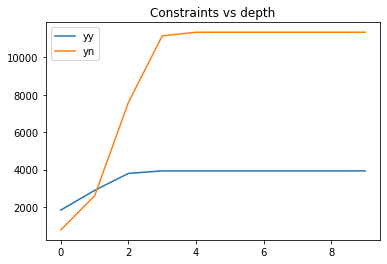

In [11]:
plt.title("Constraints vs depth")
plt.plot(len_yy, label="yy")
plt.plot(len_yn, label="yn")
plt.legend()
plt.show()

In [12]:
for c1, c2 in constraints_yn:
    if c1 == c2:
        print(c1, c2)
        break

In [13]:
dict_nn = {}
for s, t in constraints_nn:
    if s in dict_nn:
        dict_nn[s].add(t)
    else:
        dict_nn[s] = {t}

In [14]:
neighbors = {}
num_neighbors = {}
for s in list(dict_yy.keys()) + list(dict_yn.keys()) + list(dict_nn.keys()):
    neighbors[s] = dict_yy.get(s, set()).union(dict_yn.get(s, set())).union(dict_nn.get(s, set()))
    num_neighbors[s] = len(neighbors[s])

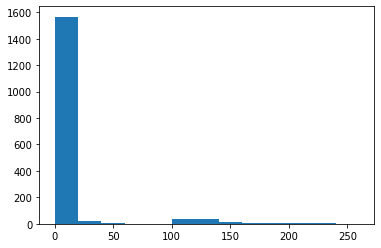

In [15]:
plt.hist(num_neighbors.values(), bins=range(0, max(num_neighbors.values()) + 1, 20))
plt.show()

Case | Equivalent implications   | Contradictory case
a    | 1 -> not 2 == 2 -> not 1  | 1 & 2
b    | 1 -> 2 == not 2 -> not 1  | 1 & not 2
c    | 2 -> 1 == not 1 -> not 2  | not 1 & 2
d    | not 1 -> 2 == not 2 -> 1  | not 1 & not 2

In [16]:
def check_constraints(relation1, true1, relation2, true2):
    # Is (relation1, true1) & (relation2, true2)  
    if true1 and true2: # Case a
        implies12 = (relation1, relation2) in constraints_yy
        implies21 = (relation2, relation1) in constraints_yy
        contradicts = (relation1, relation2) in constraints_yn or (relation2, relation1) in constraints_yn
    elif true1 and not true2: # Case b
        implies12 = (relation1, relation2) in constraints_yn or (relation2, relation1) in constraints_yn
        implies21 = False
        contradicts = (relation1, relation2) in constraints_yy
    elif not true1 and true2: # Case c
        implies12 = False
        implies21 = (relation1, relation2) in constraints_yn or (relation2, relation1) in constraints_yn
        contradicts = (relation2, relation1) in constraints_yy
    else: # Case d
        implies12 = (relation2, relation1) in constraints_yy
        implies21 = (relation1, relation2) in constraints_yy
        contradicts = False
    return implies12, implies21, contradicts

In [17]:
print(check_constraints("IsA,animal", True, "IsA,mammal", True))
print(check_constraints("IsA,animal", True, "IsA,mammal", False))
print(check_constraints("IsA,animal", False, "IsA,mammal", True))
print(check_constraints("IsA,animal", False, "IsA,mammal", False))

(False, True, False)
(False, False, False)
(False, False, True)
(True, False, False)


In [18]:
print(check_constraints("IsA,animal", True, "IsA,candy", True))
print(check_constraints("IsA,animal", True, "IsA,candy", False))
print(check_constraints("IsA,animal", False, "IsA,candy", True))
print(check_constraints("IsA,animal", False, "IsA,candy", False))

(False, False, False)
(False, False, False)
(False, False, False)
(False, False, False)


# Load models

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
# Downloads a pretty large model
tokenizer = AutoTokenizer.from_pretrained("allenai/macaw-large")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/macaw-large")
model = model.to(device=device).eval()

In [21]:
# QA Model stuff
def format_question(question_list):
    question_list = ["$answer$ ; $mcoptions$ = (A) yes (B) no; $question$ = " + item \
         for item in question_list]
    return question_list

def predict(question_list, max_bsize=10):
    B = len(question_list)
    question_list = format_question(question_list)
    answer_list_all_yes = ["$answer$ = yes"] * B     # pass in list of "yes"
    
    answers_all = []
    confidences_all = []
    for i in range(0, B, max_bsize):
        j = min(i + max_bsize, B)
        # print(dir(tokenizer))
        inputs = tokenizer.batch_encode_plus(question_list[i:j], max_length = 256, padding=True, truncation=True, return_tensors="pt")
        labels = tokenizer.batch_encode_plus(answer_list_all_yes[i:j], max_length = 15, padding=True, truncation=True, return_tensors="pt") # max_length is set to len("$answer$ = yes")

        # output = model.generate(input_ids, max_length=200)
        # answers = tokenizer.batch_decode(output, skip_special_tokens=True)
        fwd = model(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"].to(device),
                    labels=labels["input_ids"].to(device))
                    # decoder_input_ids=labels["input_ids"], decoder_attention_mask=labels["attention_mask"])
        # output_ids = torch.argmax(fwd.logits, dim=-1)
        # print(tokenizer.batch_decode(output_ids, skip_special_tokens=True))

        # loss
        # loss = fwd.loss # - log(P(y|x))
        # confidence = torch.exp(-loss)
        logits = fwd.logits.reshape((j - i, 7, -1))
        logits = logits[:, 5, :] # Index of yes/no token in answer
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        # yes has input_id 4273, no has input_id 150
        confidence_yes = probs[..., 4273] 
        confidence_no = probs[..., 150]

        answers = (confidence_yes >= confidence_no) # np.array([(ans == "$answer$ = yes") for ans in answers])
        confidences = np.where(answers, confidence_yes, confidence_no)
        answers_all.append(answers)
        confidences_all.append(confidences)
    answers = np.concatenate(answers_all, axis=0)
    confidences = np.concatenate(confidences_all, axis=0)
    return answers, confidences


In [22]:
nli_tokenizer = AutoTokenizer.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")
nli_model = AutoModelForSequenceClassification.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")
nli_model = nli_model.to(device=device).eval()

Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
def nli(sents, nli_tokenizer, nli_model, max_bsize=20):
    """Generates contradiction matrix of shape (N, B, B)"""
    if sents.ndim == 1:
        sents = sents.reshape(1, -1)
    
    N, B = sents.shape
    prem = []
    hypo = []
    for i in range(N):
        for j in range(B):
            for k in range(B):
                prem.append(sents[i][j])
                hypo.append(sents[i][k])

    nli_matrix = []
    size = N * B * B
    for i in range(0, size, max_bsize):
        j = min(i + max_bsize, size)
        tokenized = nli_tokenizer(prem[i:j], hypo[i:j], 
                                  max_length=256, 
                                  return_token_type_ids=True, 
                                  truncation=True,
                                  padding=True)

        input_ids = torch.Tensor(tokenized['input_ids']).to(device).long()
        token_type_ids = torch.Tensor(tokenized['token_type_ids']).to(device).long()
        attention_mask = torch.Tensor(tokenized['attention_mask']).to(device).long()

        nli_outputs = nli_model(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=None)
        nli_matrix.append(torch.softmax(nli_outputs.logits.detach().cpu(), dim=1))
    nli_matrix = torch.cat(nli_matrix, dim=0)
    nli_matrix = nli_matrix.reshape(N, B, B, 3)
    return nli_matrix.numpy()

# TODO: Mimic nli model, but using constraints graph
def nli_constraints(big_batch, N, B):
    nli_matrix = np.zeros((N, B, B, 3))
    pass

In [24]:
def evaluate(predictions, answers, pred_batch):
    if predictions.ndim == 1:
        predictions = predictions.reshape(1, -1)
    answers = answers.reshape(predictions.shape)
    relations = np.array([rel for ent, rel, pred in pred_batch]).reshape(predictions.shape)
    N, B = predictions.shape
    # predictions, answers, relations should be size (N, B)
    
    # Calculate accurate examples
    correct = (predictions == answers)
    acc = np.sum(correct)
    
    # Calculate metrics for F1
    TP = np.sum(correct * answers)
    TN = acc - TP
    FN = np.sum((1 - correct) * answers)
    FP = np.sum((1 - correct) * (1 - answers))
    
    # Calculate contradictions
    con = 0
    conacc = 0
    relevant = 0 # Number of pairs that imply or contradict each other
    for i in range(N):
        for j in range(B):
            for k in range(j+1, B):
                impl12, impl21, contra = check_constraints( \
                    relations[i, j], predictions[i, j], relations[i, k], predictions[i, k])
                if impl12 or impl21 or contra:
                    relevant += 1
                if contra:
                    con += 1
                else:
                    conacc += (correct[i, j] and correct[i, k])
    
    total = predictions.size
    bsize = predictions.shape[0]
    return {
        "accurate": acc,
        "TP": TP,
        "TN": TN,
        "FN": FN,
        "FP": FP,
        "contradictory_pairs": con,
        "consistent_acc_pairs": conacc,
        "relevant_pairs": relevant,
        "total_questions": predictions.size,
        "num_batches": bsize,
    }

In [25]:
def counts_tostr(counts, i):
    lines = []
    N = counts["num_batches"][i]
    total = counts["total_questions"][i]
    B = total // N
    total_pairs = N * B * (B - 1) // 2 # pairs per batch
    accurate = counts['accurate'][i]
    contradictions = counts['contradictory_pairs'][i]
    relevant = counts['relevant_pairs'][i]
    con_acc = counts['consistent_acc_pairs'][i]
    flips = counts['flips'][i]
    TP = counts['TP'][i]
    FP = counts['FP'][i]
    FN = counts['FN'][i]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 0 if precision == 0 and recall == 0 else 2 * precision * recall / (precision + recall)
    lines.append(f"Accurate {accurate} / {total} = {accurate / total}")
    lines.append(f"Precision {precision}, recall {recall} ==> F1 {f1}")
    lines.append(f"Contradictions {contradictions} / {total_pairs} pairs = {contradictions / total_pairs}")
    lines.append(f"Contradictions {contradictions} / {relevant} relevant pairs = {contradictions / relevant}")
    lines.append(f"Consistent+Accurate {con_acc} / {total_pairs} pairs = {con_acc / total_pairs}")
    lines.append(f"Corrections {flips} / {N} batches = {flips / N}")
    return "\n".join(lines)

Sampling methods
1. base fact -> relation(s) on graph (must be downstream, or upstream if false)
    Pro: Facts are close together
    Con: Limited to guaranteed relations, so asymmetric
2. base fact -> sample given facts that are nearby (not necessarily downstream)
    Pro: Symmetric since all facts are given, facts are close together
    Con: Contradictions may be a bit dense
3. sample facts randomly (then just check afterwards)
    Pro: Symmetric since all facts are given, sparser contradictions
    Con: Facts may be distant, and constraints aren't complete, so will miss some constraints

In [26]:
print(predict(["Is a buffalo a mammal?", "Is a buffalo not a mammal?"], max_bsize=20))  # QA Model
print(predict(["Is a buffalo a water animal?", "Is a buffalo not a water animal?"], max_bsize=20))  # QA Model
generate_inverse_question("buffalo", "IsA,mammal", "true")


(array([ True, False]), array([0.9846942, 0.9998914], dtype=float32))
(array([ True, False]), array([0.92805856, 0.9997551 ], dtype=float32))


('Is a buffalo not a mammal?', 'Yes')

### QA Requerying

In [ ]:
# def requery_with_context(old_predictions, old_confidences, questions, nli_matrix, big_batch, return_flip_mask=False):
#     contra_matrix = nli_matrix[:, :, :, 2]
#     contra_matrix = (contra_matrix + contra_matrix.transpose((0, 2, 1))) / 2
#     contra_matrix[:, range(B), range(B)] = 0 # Set diagonals to 0

    
#     correction_fn = getattr(correction_utils, 'C_1') # Apply C_1 correction function first
#     corrected, flip = correction_fn(old_predictions, old_confidences, nli_matrix, return_flip_mask=True)
 
#     # For each elem in big_batch that should be flipped, invert question (answer remains same)
#     big_batch[:, :, 2] = np.logical_xor(big_batch[:, :, 2] == "True", flip) # Note: big_batch is modified
#     # Current answer | Flip? -> New Answer (XOR)
#     # 0 1 -> 1
#     # 0 0 -> 0
#     # 1 0 -> 1
#     # 1 1 -> 0

#     # Requery QA model with inverted question if flipped
#     requeried_questions = []
#     for ij in np.ndindex(big_batch.shape[:2]): # convert to orig big_batch format
#         entity, relation, flipped = tuple(big_batch[ij])
#         if(flipped): # flipped
            


In [68]:
### Re-querying NLI/QA models
# Patrick Liu the goat's sage advice:
'''
If A and B contradict, and you decide to flip B, then you have the same batch but with ~B
Get the NLI with ~B (not entire matrix, just corresponding row/col -- compare ~B with the rest of batch)
Then, if it contradicts with anything else in the batch, repeat
'''

def requery_inverted(old_predictions, old_confidences, questions, nli_matrix, big_batch, return_flip_mask=False):
    big_batch = np.array(big_batch).reshape(N,B,3) # (entity, rel, label) in last axis
    questions = np.array(questions).reshape(N,B)

    correction_fn = getattr(correction_utils, 'C_1') # Apply C_1 correction function first
    corrected, flip = correction_fn(old_predictions, old_confidences, nli_matrix, return_flip_mask=True)
 

    # For each elem in big_batch that should be flipped, invert question (answer remains same)
    big_batch[:, :, 2] = np.logical_xor(big_batch[:, :, 2] == "True", flip) # Note: big_batch is modified
    # Current answer | Flip? -> New Answer (XOR)
    # 0 1 -> 1
    # 0 0 -> 0
    # 1 0 -> 1
    # 1 1 -> 0

    # Requery QA model with inverted question if flipped
    requeried_questions = []
    for ij in np.ndindex(big_batch.shape[:2]): # convert to orig big_batch format
        entity, relation, flipped = tuple(big_batch[ij])
        if(flipped): # flipped
            new_q, _ = generate_inverse_question(entity, relation, flipped)
        else: 
            new_q, _ = generate_question(entity, relation, flipped)
        requeried_questions.append(new_q)
    
    new_predictions, new_confidences = predict(requeried_questions, max_bsize=20) # QA Model
    new_predictions = new_predictions.reshape(N,B)
    new_confidences = new_confidences.reshape(N,B)
    changed_predictions = np.logical_xor(new_predictions, old_predictions) # Predictions that have changed with requery
    # print("Predictions that have changed with QA requery: " + changed_predictions)
    # print(new_confidences, old_confidences, new_predictions, old_predictions)

    # Take the prediction with the higher confidence score
    combined_max_predictions = np.where(new_confidences > old_confidences, new_predictions, old_predictions)
    # print(combined_max_confidences)

    # Output stage
    corrected = combined_max_predictions.copy()
    flip = np.logical_xor(corrected, old_predictions)
    if return_flip_mask:
        return corrected, flip
    return corrected



### QA Requerying Eval

In [67]:
start = time.time()

correction_fn_names = ['QA Requerying']


counts = { 
    k: np.zeros(len(correction_fn_names), dtype=int) 
    for k in [
        "accurate", "TP", "TN", "FN", "FP", "contradictory_pairs", "consistent_acc_pairs", 
        "relevant_pairs", "total_questions", "num_batches", "flips"
    ]
}

N = 10 # Number of entities to sample in a big batch
batch_counter = 0
num_batches = 0
num_big_batches = 0
big_batch = []

B = 10 # Number of facts for each entity
random.shuffle(dev_entities)
idx_count = 0
idx = 0
while num_batches < 1000:
    if idx == len(dev_entities):
        random.shuffle(dev_entities)
        idx = 0
    entity = dev_entities[idx]
    idx += 1
    idx_count += 1
    
    # Sample set of facts for an entity
    # Sampling method 2
    entity_facts = list(facts[entity].items())
    base = random.choice(entity_facts)
    relation, label = base
    nearby = neighbors.get(relation, set())
    allowed_facts = [f for f in entity_facts if f[0] in nearby]
    if len(allowed_facts) < B - 1:
        continue
    batch = random.sample(allowed_facts, min(B - 1, len(allowed_facts)))
    batch = [base] + batch
    batch = [(entity, rel, label == "yes") for rel, label in batch]
    

    # # Random sampling (method 3)
    # batch = random.sample(list(facts[entity].items()), B)
    # batch = [(entity, relation, true == "yes") for relation, yes in batch]
    
    # Collect batches in big batches
    if batch_counter == 0:
        big_batch = []
    batch_counter += 1
    big_batch.extend(batch)
    if batch_counter < N: # Big batch not full yet, keep accumulating examples
        continue
    # We have a full batch
    batch_counter = 0
    num_batches += N
    num_big_batches += 1
    
    questions, answers = zip(*[generate_question(*tup) for tup in big_batch])
    questions = list(questions)
    answers = np.array(answers) == "Yes"
    # print("Questions:", questions)
    # print("Labels (for contradiction):", answers)
    
    predictions, confidences = predict(questions, max_bsize=20)
    predictions = predictions.flatten()
    confidences = confidences.flatten()
    # print("QA predictions:", predictions)
    # print("QA confidences:", confidences)
    
    pred_batch = [(ent, rel, predictions[i]) for i, (ent, rel, true) in enumerate(big_batch)]
    assertions = [generate_assertion(*tup) for tup in pred_batch]
    # print("Assertions:", assertions)
    
    assertions = np.array(assertions).reshape(N, B)
    nli_matrix = nli(assertions, nli_tokenizer, nli_model, max_bsize=20)
    # print("NLI probability matrix:\n", nli_matrix)
    
    predictions = predictions.reshape(N, B)
    confidences = confidences.reshape(N, B)

    ### Evaluate with NLI Requerying
    for i, _ in enumerate(correction_fn_names):
        corrected, flip_mask = requery_inverted(predictions.copy(), confidences.copy(), questions.copy(), nli_matrix.copy(), big_batch.copy(), return_flip_mask = True)
        counts['flips'][i] += np.count_nonzero(flip_mask)
        eval_dict = evaluate(corrected, answers, pred_batch)
        for k, v in eval_dict.items():
            counts[k][i] += v
    # print(eval_dict)
    
    if num_batches % 100 == 0:
        print(f"Iter {idx_count}: {num_batches} batches, {counts['total_questions'][0]} questions")
        for i, correction_fn in enumerate(correction_fn_names):
            print(f"Correction function {correction_fn}:")
            print('\t' + counts_tostr(counts, i).replace('\n', '\n\t'))
            
print("\n==================== Final Results ====================")
print(f"End on iter {idx_count}: {num_batches} {B}x{B} batches, {counts['total_questions'][0]} questions")
for i, correction_fn in enumerate(correction_fn_names):
    print(f"Correction function {correction_fn}:")
    print('\t' + counts_tostr(counts, i).replace('\n', '\n\t'))

end = time.time()
print("Runtime:", end - start)


Iter 105: 100 batches, 1000 questions
Correction function QA Requerying:
	Accurate 940 / 1000 = 0.94
	Precision 0.9142857142857143, recall 0.3595505617977528 ==> F1 0.5161290322580646
	Contradictions 1 / 4500 pairs = 0.00022222222222222223
	Contradictions 1 / 362 relevant pairs = 0.0027624309392265192
	Consistent+Accurate 3981 / 4500 pairs = 0.8846666666666667
	Corrections 245 / 100 batches = 2.45
Iter 216: 200 batches, 2000 questions
Correction function QA Requerying:
	Accurate 1871 / 2000 = 0.9355
	Precision 0.9193548387096774, recall 0.3149171270718232 ==> F1 0.4691358024691357
	Contradictions 9 / 9000 pairs = 0.001
	Contradictions 9 / 803 relevant pairs = 0.0112079701120797
	Consistent+Accurate 7890 / 9000 pairs = 0.8766666666666667
	Corrections 498 / 200 batches = 2.49
Iter 325: 300 batches, 3000 questions
Correction function QA Requerying:
	Accurate 2805 / 3000 = 0.935
	Precision 0.9186046511627907, recall 0.2958801498127341 ==> F1 0.4475920679886686
	Contradictions 15 / 13500 pa

### Other Evaluation Function Eval

In [65]:
start = time.time()

# correction_fn_names = ['C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'C_8']
correction_fn_names = ['C_0', 'C_1']
correction_fns = [getattr(correction_utils, fn_name) for fn_name in correction_fn_names]


counts = { 
    k: np.zeros(len(correction_fns), dtype=int) 
    for k in [
        "accurate", "TP", "TN", "FN", "FP", "contradictory_pairs", "consistent_acc_pairs", 
        "relevant_pairs", "total_questions", "num_batches", "flips"
    ]
}

N = 10 # Number of entities to sample in a big batch
batch_counter = 0
num_batches = 0
num_big_batches = 0
big_batch = []

B = 10 # Number of facts for each entity
random.shuffle(dev_entities)
idx_count = 0
idx = 0
while num_batches < 10:
    if idx == len(dev_entities):
        random.shuffle(dev_entities)
        idx = 0
    entity = dev_entities[idx]
    idx += 1
    idx_count += 1
    
    # Sample set of facts for an entity
    # Sampling method 2
    entity_facts = list(facts[entity].items())
    base = random.choice(entity_facts)
    relation, label = base
    nearby = neighbors.get(relation, set())
    allowed_facts = [f for f in entity_facts if f[0] in nearby]
    if len(allowed_facts) < B - 1:
        continue
    batch = random.sample(allowed_facts, min(B - 1, len(allowed_facts)))
    batch = [base] + batch
    batch = [(entity, rel, label == "yes") for rel, label in batch]
    

    # # Random sampling (method 3)
    # batch = random.sample(list(facts[entity].items()), B)
    # batch = [(entity, relation, true == "yes") for relation, yes in batch]
    
    # Collect batches in big batches
    if batch_counter == 0:
        big_batch = []
    batch_counter += 1
    big_batch.extend(batch)
    if batch_counter < N: # Big batch not full yet, keep accumulating examples
        continue
    # We have a full batch
    batch_counter = 0
    num_batches += N
    num_big_batches += 1
    
    questions, answers = zip(*[generate_question(*tup) for tup in big_batch])
    questions = list(questions)
    answers = np.array(answers) == "Yes"
    # print("Questions:", questions)
    # print("Labels (for contradiction):", answers)
    
    predictions, confidences = predict(questions, max_bsize=20)
    predictions = predictions.flatten()
    confidences = confidences.flatten()
    # print("QA predictions:", predictions)
    # print("QA confidences:", confidences)
    
    pred_batch = [(ent, rel, predictions[i]) for i, (ent, rel, true) in enumerate(big_batch)]
    assertions = [generate_assertion(*tup) for tup in pred_batch]
    # print("Assertions:", assertions)
    
    assertions = np.array(assertions).reshape(N, B)
    nli_matrix = nli(assertions, nli_tokenizer, nli_model, max_bsize=20)
    # print("NLI probability matrix:\n", nli_matrix)
    
    predictions = predictions.reshape(N, B)
    confidences = confidences.reshape(N, B)

    ### Evaluate with NLI Requerying
    # corrected, flip_mask = requery_correction_fn(predictions.copy(), confidences.copy(), questions.copy(), nli_matrix.copy(), big_batch.copy(), return_flip_mask = True)
    # counts['flips'][i] += np.count_nonzero(flip_mask)
    # eval_dict = evaluate(corrected, answers, pred_batch)
    # for k, v in eval_dict.items():
    #     counts[k][i] += v


    ### Evaluate with correction functions
    for i, correction_fn in enumerate(correction_fns):
        corrected, flip_mask = correction_fn(predictions.copy(), confidences.copy(), nli_matrix.copy(), return_flip_mask=True)
        counts['flips'][i] += np.count_nonzero(flip_mask)
        eval_dict = evaluate(corrected, answers, pred_batch)
        for k, v in eval_dict.items():
            counts[k][i] += v
    # print(eval_dict)
    
    if num_batches % 100 == 0:
        print(f"Iter {idx_count}: {num_batches} batches, {counts['total_questions'][0]} questions")
        for i, fn_name in enumerate(correction_fn_names):
            print(f"Correction function {fn_name}:")
            print('\t' + counts_tostr(counts, i).replace('\n', '\n\t'))
            
print("\n==================== Final Results ====================")
print(f"End on iter {idx_count}: {num_batches} {B}x{B} batches, {counts['total_questions'][0]} questions")
for i, fn_name in enumerate(correction_fn_names):
    print(f"Correction function {fn_name}:")
    print('\t' + counts_tostr(counts, i).replace('\n', '\n\t'))

end = time.time()
print("Runtime:", end - start)



==================== Final Results ====================
End on iter 17: 16 10x10 batches, 160 questions
Correction function C_0:
	Accurate 135 / 160 = 0.84375
	Precision 0.2857142857142857, recall 1.0 ==> F1 0.4444444444444445
	Contradictions 21 / 720 pairs = 0.029166666666666667
	Contradictions 21 / 216 relevant pairs = 0.09722222222222222
	Consistent+Accurate 514 / 720 pairs = 0.7138888888888889
	Corrections 0 / 16 batches = 0.0
Correction function C_1:
	Accurate 147 / 160 = 0.91875
	Precision 0.43478260869565216, recall 1.0 ==> F1 0.6060606060606061
	Contradictions 4 / 720 pairs = 0.005555555555555556
	Contradictions 4 / 139 relevant pairs = 0.02877697841726619
	Consistent+Accurate 609 / 720 pairs = 0.8458333333333333
	Corrections 14 / 16 batches = 0.875
Runtime: 19.188462018966675


In [29]:
now = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
print(now)

2022-03-12T08:08:16


In [30]:
df_dict = counts.copy()
df_dict['correction_fn'] = correction_fn_names
df = pd.DataFrame(df_dict)
df = df[['correction_fn'] + [k for k in counts.keys()]]
df.to_csv(f'results/{now}.csv', index=False)

In [31]:
# now = "2022-02-26T06:34:50"
df = pd.read_csv(f'results/{now}.csv')
df

,correction_fn,accurate,TP,TN,FN,FP,contradictory_pairs,consistent_acc_pairs,relevant_pairs,total_questions,num_batches,flips
0,C_0,136,19,117,2,22,14,517,195,160,16,0
1,C_1,146,19,127,2,12,8,601,125,160,16,16


In [32]:
correction_fn_names = df['correction_fn'].to_numpy()
for k in df.columns:
    if k == 'correction_fn':
        continue
    print(k)
    exec(f"{k} = df['{k}'].to_numpy()")

accurate
TP
TN
FN
FP
contradictory_pairs
consistent_acc_pairs
relevant_pairs
total_questions
num_batches
flips


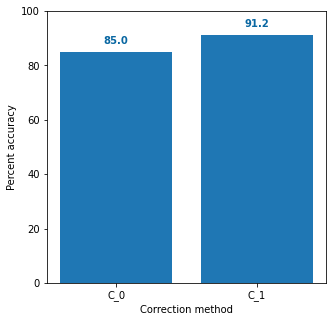

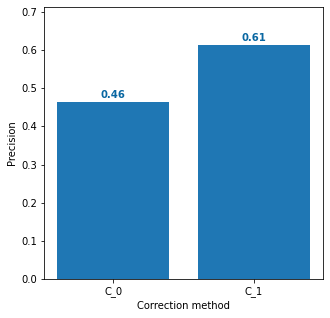

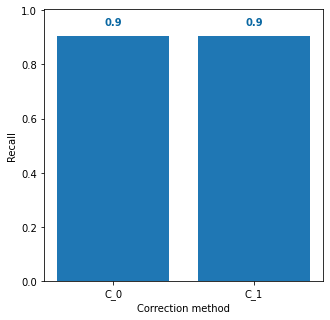

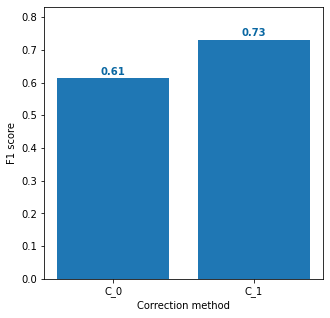

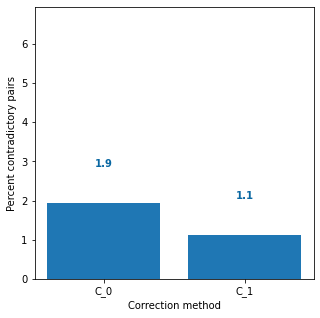

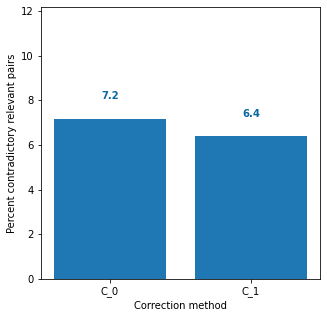

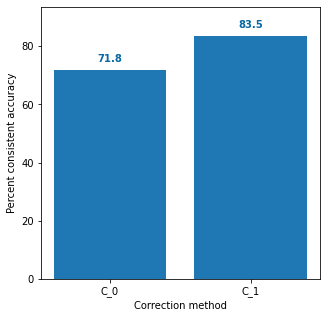

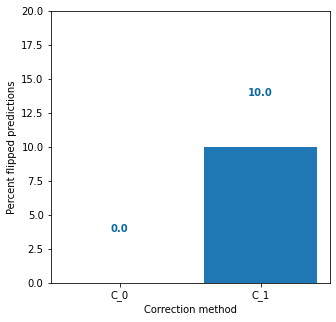

In [33]:
accuracies = accurate / total_questions * 100
precisions = TP / (TP + FP)
recalls = TP / (TP + FN)
f1_scores = 2 * TP / (2 * TP + FP + FN)
contra_rates = contradictory_pairs / (num_batches * B * (B - 1) / 2) * 100
relevant_contra_rates = contradictory_pairs / relevant_pairs * 100
conacc_rates = consistent_acc_pairs / (num_batches * B * (B - 1) / 2) * 100
flip_rates = (flips / total_questions) * 100
if not os.path.isdir(f"figures/{now}"):
    os.mkdir(f"figures/{now}")

figsize = (5,5)
fig, ax = plt.subplots(figsize=figsize)
ax.bar(correction_fn_names, accuracies)
for i, v in enumerate(accuracies):
    ax.text(i, v + 1 + max(accuracies) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, 100)
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent accuracy")
plt.show()
fig.savefig(f"figures/{now}/accuracy.png")

figsize = (5,5)
fig, ax = plt.subplots(figsize=figsize)
ax.bar(correction_fn_names, precisions)
for i, v in enumerate(precisions):
    ax.text(i, v + 0.02, str(round(v, 2)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(precisions + 0.1), 1.05))
ax.set_xlabel("Correction method")
ax.set_ylabel("Precision")
plt.show()
fig.savefig(f"figures/{now}/precision.png")

figsize = (5,5)
fig, ax = plt.subplots(figsize=figsize)
ax.bar(correction_fn_names, recalls)
for i, v in enumerate(recalls):
    ax.text(i, v + 0.05, str(round(v, 2)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(recalls + 0.1), 1.05))
ax.set_xlabel("Correction method")
ax.set_ylabel("Recall")
plt.show()
fig.savefig(f"figures/{now}/recall.png")

figsize = (5,5)
fig, ax = plt.subplots(figsize=figsize)
ax.bar(correction_fn_names, f1_scores)
for i, v in enumerate(f1_scores):
    ax.text(i, v + 0.02, str(round(v, 2)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(f1_scores + 0.1), 1.05))
ax.set_xlabel("Correction method")
ax.set_ylabel("F1 score")
plt.show()
fig.savefig(f"figures/{now}/f1_score.png")

fig, ax = plt.subplots(figsize=figsize)
plt.bar(correction_fn_names, contra_rates)
for i, v in enumerate(contra_rates):
    ax.text(i, v + 1 + max(contra_rates) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(contra_rates) + 5, 100))
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent contradictory pairs")
plt.show()
fig.savefig(f"figures/{now}/contradict.png")

fig, ax = plt.subplots(figsize=figsize)
plt.bar(correction_fn_names, relevant_contra_rates)
for i, v in enumerate(relevant_contra_rates):
    ax.text(i, v + 1 + max(relevant_contra_rates) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(relevant_contra_rates) + 5, 100))
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent contradictory relevant pairs")
plt.show()
fig.savefig(f"figures/{now}/contradict_relevant.png") 

fig, ax = plt.subplots(figsize=figsize)
plt.bar(correction_fn_names, conacc_rates)
for i, v in enumerate(conacc_rates):
    ax.text(i, v + 1 + max(accuracies) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(conacc_rates) + 10, 100))
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent consistent accuracy")
plt.show()
fig.savefig(f"figures/{now}/consistent_accuracy.png")

fig, ax = plt.subplots(figsize=figsize)
plt.bar(correction_fn_names, flip_rates)
for i, v in enumerate(flip_rates):
    ax.text(i, v + 1 + max(accuracies) // 25, str(round(v, 1)), color="#0967a2", fontweight='semibold', ha='center', va='center')
ax.set_ylim(0, min(max(flip_rates) + 10, 100))
ax.set_xlabel("Correction method")
ax.set_ylabel("Percent flipped predictions")
plt.show()
fig.savefig(f"figures/{now}/flipped.png")